**Import libraries**

In [3]:
# import libraries
#!pip install tensorflow
#!pip install --upgrade tensorflow
#!pip install --upgrade keras
#!pip show tensorflow
#!pip install --user tensorflow
#!pip install tensorflow==2.13.1
#!pip install --upgrade scikit-learn
#!pip install keras==2.12.1
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.losses import categorical_crossentropy
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor



ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'

**import data and merge them together**

In [4]:
# import data and merge them together

# Define the path to your CSV file
file_list =[r'data/US1CASF0004.csv', r'data/US1CASF0008.csv', r'data/US1CASF0014.csv', \
            r'data/US1CASF0017.csv', r'data/US1CASF0020.csv', r'data/US1CASF0021.csv', r'data/USC00047765.csv', \
            r'data/USC00047767.csv', r'data/USW00023234.csv', r'data/USW00023272.csv']  
sf_daily = pd.read_csv('data/US1CASF0003.csv')
for filename in file_list:
        # Read the CSV file into a new DataFrame
        temp = pd.read_csv(filename)
        # Append the new data to the existing DataFrame
        sf_daily = sf_daily.append(temp, ignore_index=True)

#lower case series name
sf_daily.columns = sf_daily.columns.str.lower()
sf_daily.columns        


C:\Users\jeng_\AppData\Local\Temp\ipykernel_1472\617193738.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sf_daily = sf_daily.append(temp, ignore_index=True)
C:\Users\jeng_\AppData\Local\Temp\ipykernel_1472\617193738.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sf_daily = sf_daily.append(temp, ignore_index=True)
C:\Users\jeng_\AppData\Local\Temp\ipykernel_1472\617193738.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sf_daily = sf_daily.append(temp, ignore_index=True)
C:\Users\jeng_\AppData\Local\Temp\ipykernel_1472\617193738.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sf_daily = sf_daily.append(temp, ignore_

Index(['station', 'date', 'latitude', 'longitude', 'elevation', 'name', 'prcp',
       'prcp_attributes', 'snow', 'snow_attributes',
       ...
       'wt21', 'wt21_attributes', 'wv01', 'wv01_attributes', 'wv03',
       'wv03_attributes', 'wv20', 'wv20_attributes', 'psun',
       'psun_attributes'],
      dtype='object', length=112)

**EDA**

In [5]:
#Check missing value, there many variable with most of records are missing value
missing_values = sf_daily.isna().sum()
missing_values = missing_values.reset_index()  # Reset the index to make it a DataFrame
missing_values.columns = ['Variables', 'Missing Values']  # Rename the columns
specific_vars = ['station', 'date', 'latitude', 'longitude', 'elevation', 'name', 'prcp',
                 'prcp_attributes', 'snow', 'snow_attributes', 'snwd', 'tmax', 'tmin']

# Filter the DataFrame based on the specific variables 
filtered_missing_values = missing_values.loc[missing_values['Variables'].isin(specific_vars)]

print(filtered_missing_values)


          Variables  Missing Values
0           station               0
1              date               0
2          latitude               0
3         longitude               0
4         elevation               0
5              name               0
6              prcp            1716
7   prcp_attributes            1716
8              snow           34662
9   snow_attributes           34662
16             snwd           42917
18             tmax           13072
20             tmin           13187


In [6]:
# check data avaiability in each station

grouped = sf_daily.groupby(['station']).agg('count')

# Transpose the table using .T
transposed_table = grouped.T

# Alternatively, you can use the .transpose() method
# transposed_table = grouped.transpose()

# Now, transposed_table contains the transposed version of the grouped DataFrame
print(transposed_table.loc[['date', 'prcp', 'snow', 'snwd', 'tmax', 'tmin']])

station  US1CASF0003  US1CASF0004  US1CASF0008  US1CASF0014  US1CASF0017  \
date            1025         4979         1461          162         1169   
prcp            1024         4979         1459          153         1158   
snow             582         3900         1121            0          905   
snwd               0            0            0            0            0   
tmax               0            0            0            0            0   
tmin               0            0            0            0            0   

station  US1CASF0020  US1CASF0021  USC00047765  USC00047767  USW00023234  \
date             764          482         2185        23517        28564   
prcp             760          482         2178        21849        28562   
snow             464          297         2185        17895        18773   
snwd               0            0         2184        17679        17837   
tmax               0            0         2152        20556        28543   
tmin       

In [7]:
# I select station 'USW00023272' to build the model becuase it is the one that has the least missing value
# Then indentify missing value 
station_code = 'USW00023272'
missing_indices = sf_daily.loc[sf_daily['station'] == station_code].loc[sf_daily['prcp'].isnull()].index
missing_indices

Int64Index([ 84328,  84329,  84343,  84344,  85476,  85477,  85478,  85549,
             85550,  85903,  85904, 101851],
           dtype='int64')

In [29]:
# because the missing value is a few, I use linear interpolation to fill them 
station_code = 'USW00023272'
sf_daily_filled = sf_daily.loc[sf_daily['station'] == station_code].interpolate()
prcp = sf_daily_filled['prcp']
prcp.shape

(37544,)

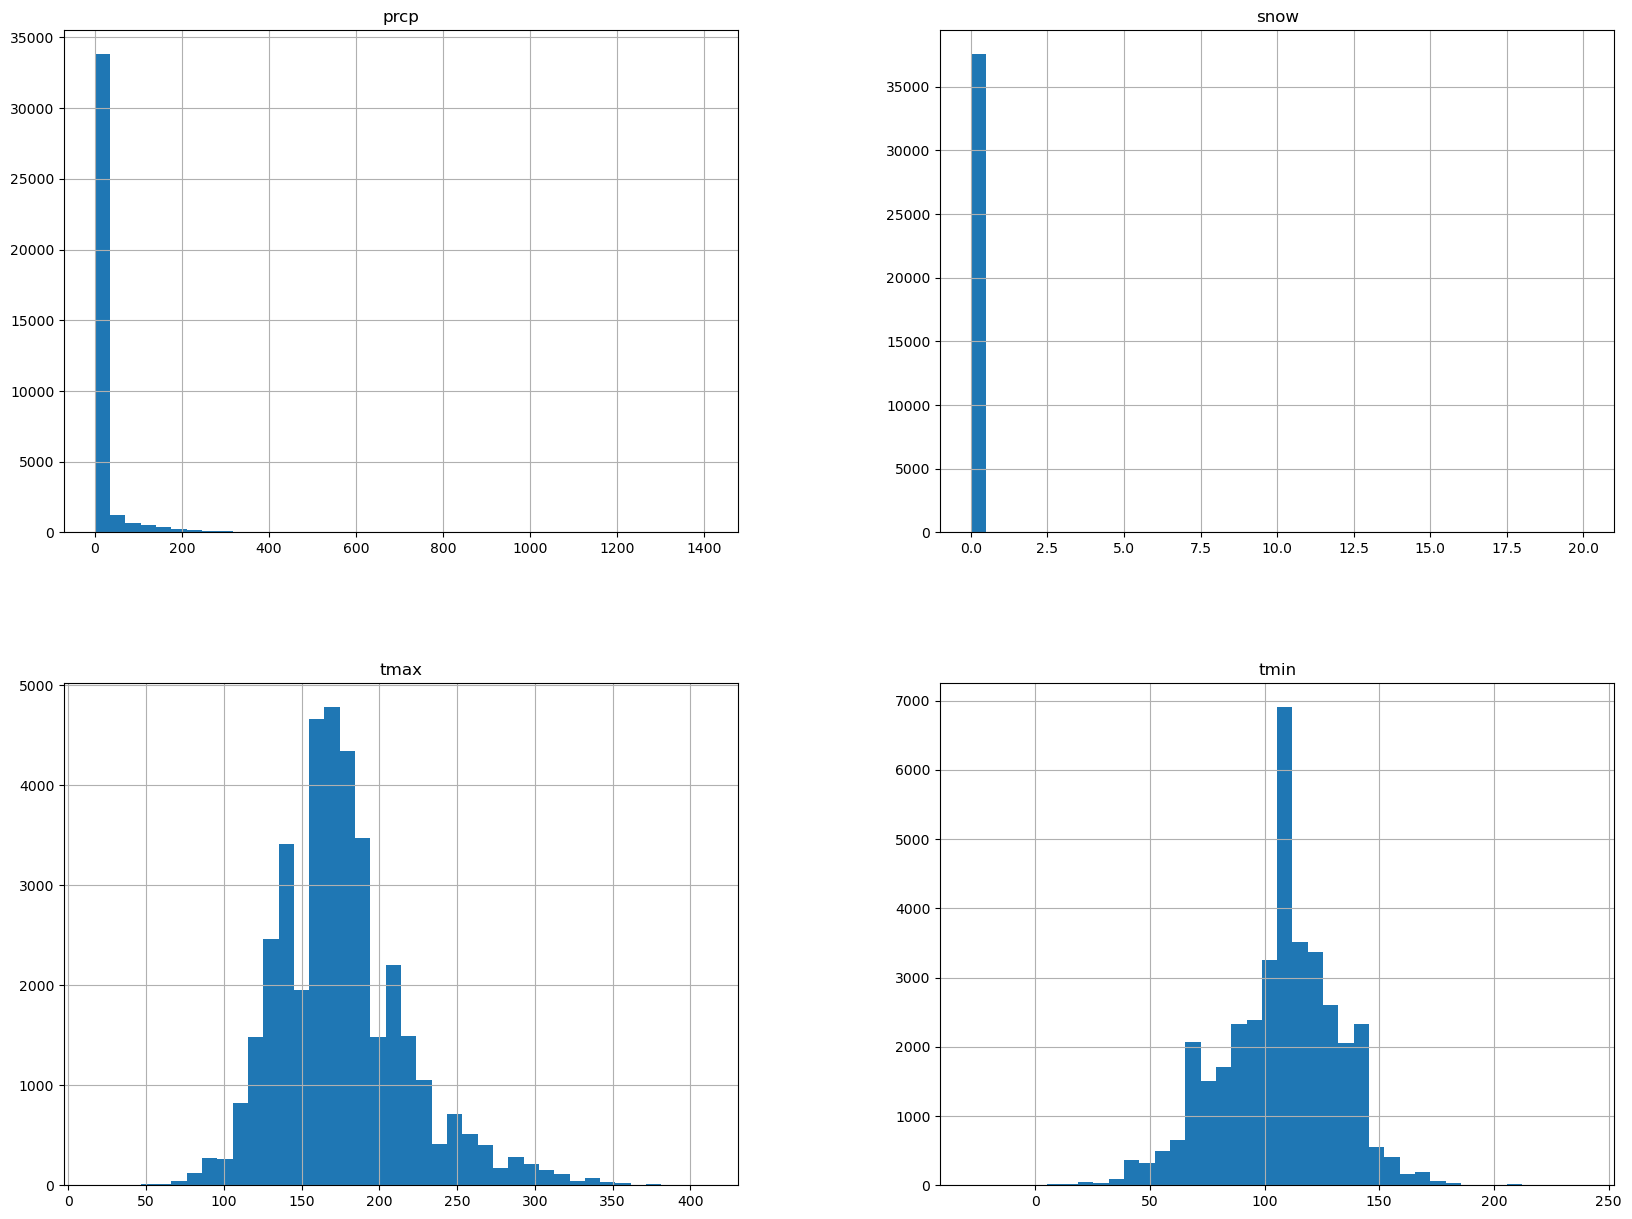

In [39]:
# EDA 4 main variables in the dataset
main4 = sf_daily_filled[['date', 'prcp', 'snow', 'tmax', 'tmin']]
#EDA plot the distributions for the variable and checking for outliers
main4.hist(bins=40, figsize=(20,15))
plt.show()

C:\Users\jeng_\AppData\Local\Temp\ipykernel_1472\1453480190.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main4['date'] = pd.to_datetime(main4['date'])


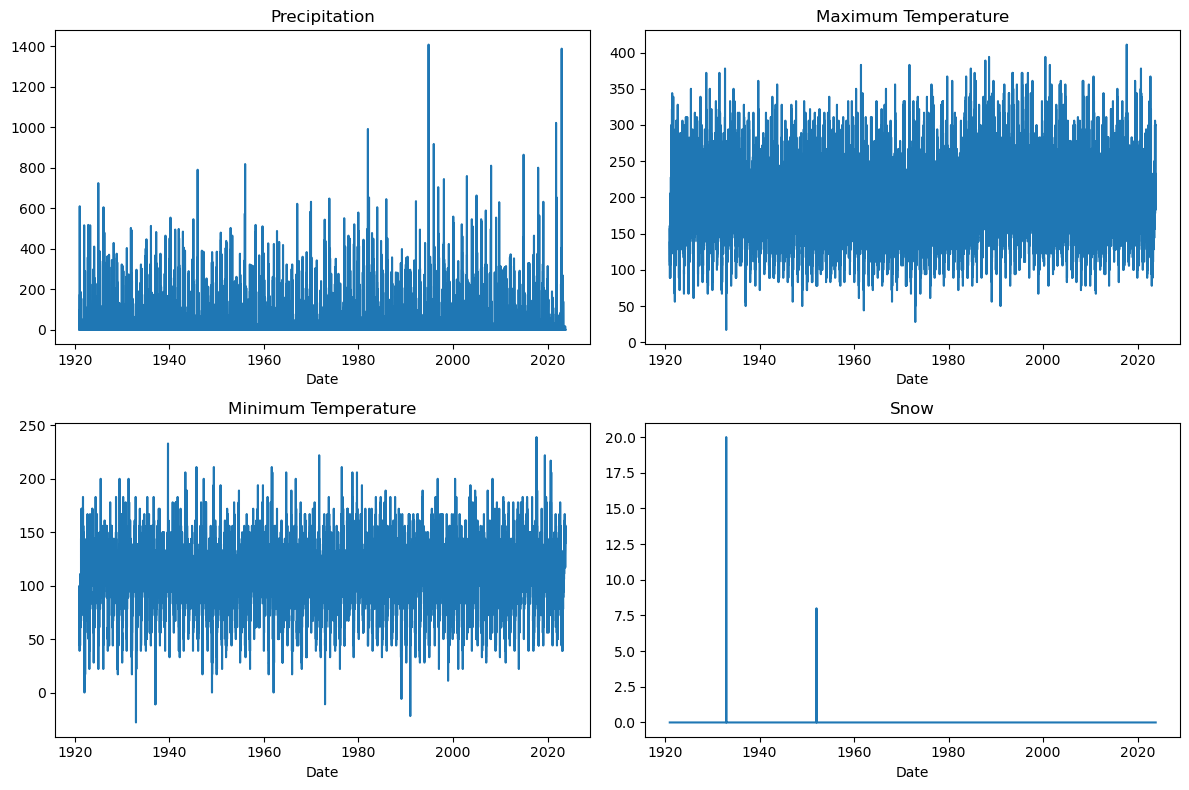

In [48]:
# Convert the date column to datetime format (if not already)
main4['date'] = pd.to_datetime(main4['date'])

# Plot "prcp" in the first chart
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(main4['date'], main4["prcp"])
plt.title('Precipitation')
plt.xlabel('Date')

# Plot "tmax" in the second chart
plt.subplot(2, 2, 2)
plt.plot(main4['date'], main4["tmax"])
plt.title('Maximum Temperature')
plt.xlabel('Date')

# Plot "tmin" in the third chart
plt.subplot(2, 2, 3)
plt.plot(main4['date'], main4["tmin"])
plt.title('Minimum Temperature')
plt.xlabel('Date')

# Plot "snow" in the fourth chart
plt.subplot(2, 2, 4)
plt.plot(main4['date'], main4["snow"])
plt.title('Snow')
plt.xlabel('Date')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [40]:
# create correlation matrix
main4.corr()

C:\Users\jeng_\AppData\Local\Temp\ipykernel_1472\443750558.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  main4.corr()


,prcp,snow,tmax,tmin
prcp,1.000000,0.002021,-0.207540,-0.084355
snow,0.002021,1.000000,-0.020710,-0.029158
tmax,-0.207540,-0.020710,1.000000,0.700709
tmin,-0.084355,-0.029158,0.700709,1.000000


**Feature engineering**

In [9]:
# generate training set for time series data
# assign 'date' with 'precipitation' series
data = prcp.values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

# Prepare data for LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length:i+seq_length+1]
        sequences.append((seq, label))
    return np.array([s[0] for s in sequences]), np.array([s[1] for s in sequences])

seq_length = 30  # Adjust as needed
X, y = create_sequences(data_normalized, seq_length)

In [10]:
# Reshape X to 2D array
X_reshaped = X.reshape(X.shape[0], -1)

# Reshape y to 1D array
y_reshaped = y[:, 0, 0]  # Assuming y has shape (num_samples, 1, 1)
y_reshaped.shape
X_train =X_reshaped[:30209,:]
X_test =X_reshaped[30209:,:]
y_train =y_reshaped[:30209]
y_test =y_reshaped[30209:]

**Ridge regression model**

In [27]:
# Ridge regression model
#-----------
#import libraries
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# create function to calculate the root mean squared errror
def mse(pred, actual):
    return np.mean((pred - actual) ** 2)

# make and fit a Ridge regression model
ridge_reg = Ridge()                                              # create the model
ridge_model = ridge_reg.fit(X_train, y_train)                    # fit the model

# specify the hyperparameters
param_grid = {'alpha': np.arange(.1, 1, .1),
              'fit_intercept': [True, False],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr']}

# execute the grid search
ridge_grid_reg = GridSearchCV(ridge_reg,  # model to be tuned
                              param_grid, # parameters to be searched as specified above
                              cv=5)       # 5-fold cross-validation to be used during hypertuning

# fit the tuning on the training data
ridge_grid_reg.fit(X_train, y_train)

# select the best performing model and predict with that on training set 
best_index = np.argmax(ridge_grid_reg.cv_results_["mean_test_score"])  # find the best performing model
best_ridge_pred = ridge_grid_reg.best_estimator_.predict(X_train)   # find best estimator and predict on training

# Ridge model using the test dataset and the trained model, predict
best_ridge_pred = ridge_grid_reg.best_estimator_.predict(X_test)   # find best estimator and predict on validate

# print the results  
print(ridge_grid_reg.cv_results_["params"][best_index])
print('Ridge Best CV R^2:', max(ridge_grid_reg.cv_results_["mean_test_score"]))
print('Ridge Validation R^2:', ridge_grid_reg.score(X_test, y_test))
print('Ridge Validation MSE', rmse(best_ridge_pred, y_test))

{'alpha': 0.9, 'fit_intercept': True, 'solver': 'lsqr'}
Ridge Best CV R^2: 0.11707577458561721
Ridge Validation R^2: 0.10596755860389406
Ridge Validation MSE 0.03831704483774142


**ARIMA Model**

In [20]:
#!pip install statsmodels
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Assuming you have a univariate time series
y_train = pd.Series(y_train)

# Choose the order (p, d, q) for ARIMA. You may need to tune these values.
order = (20, 1, 20)  # Replace p, d, q with appropriate values

# Train ARIMA model
model = ARIMA(y_train, order=order)
model_fit = model.fit()

# Print summary of the model
print(model_fit.summary())

# Get the residuals
#residuals = pd.DataFrame(model_fit.resid)

# Plot residuals to check for patterns
#residuals.plot()
#plt.show()

# Forecast on the test set
y_pred = model_fit.forecast(steps=len(y_test))

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on Test Set: {mse}")

"""
# Plot the actual vs predicted values
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()
"""

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                30209
Model:               ARIMA(20, 1, 20)   Log Likelihood               57439.089
Date:                Mon, 27 Nov 2023   AIC                        -114796.179
Time:                        20:31:35   BIC                        -114455.228
Sample:                             0   HQIC                       -114686.817
                              - 30209                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6983      1.058     -0.660      0.509      -2.772       1.375
ar.L2         -0.5355      1.396     -0.384      0.701      -3.271       2.200
ar.L3         -0.5690      1.103     -0.516      0.6

"\n# Plot the actual vs predicted values\nplt.plot(y_test, label='Actual')\nplt.plot(y_pred, label='Predicted')\nplt.legend()\nplt.show()\n"

**XGboost Model**

In [11]:
# import libraries for xgboost
#!pip install xgboost
import time
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

# record the start time
start_time = time.time()

# initialize an xgb regressor
xgb_regressor = xgb.XGBRegressor(random_state=10)

# define a hyperparameter grid
param_grid = {
    'n_estimators': [20, 50, 100, 150],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# perform grid search with time series cross-validation
grid_search = GridSearchCV(xgb_regressor, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# get the best parameters
best_params = grid_search.best_params_

# use the best parameters to train the final model
final_model_xgb = xgb.XGBRegressor(random_state=10, **best_params)
final_model_xgb.fit(X_train, y_train)

# make predictions on the test set
y_pred = final_model_xgb.predict(X_test)

# evaluate the final model using appropriate metrics for regression
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# print the best hyperparameters and metrics
print(f"Best Hyperparameters: {best_params}")
print(f"\nMean Squared Error: {mse} \nMean Absolute Error: {mae}")
print(f"\nRuntime: {time.time() - start_time} seconds")

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}

Mean Squared Error: 0.0014351283049242923 
Mean Absolute Error: 0.014582961913706227

Runtime: 438.43178725242615 seconds
